In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

21:07:35 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=911208;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=38056;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=281379;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=621632;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=470944;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=307406;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

21:07:38 ERROR     error                                                                           ]8;id=627952;file:///var/folders/q8/68hhzv8d7tq6gcjbsy0347_r0000gn/T/ipykernel_17048/3699701126.py\3699701126.py]8;;\:]8;id=685379;file:///var/folders/q8/68hhzv8d7tq6gcjbsy0347_r0000gn/T/ipykernel_17048/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=434531;file:///var/folders/q8/68hhzv8d7tq6gcjbsy0347_r0000gn/T/ipykernel_17048/3699701126.py\3699701126.py]8;;\:]8;id=475251;file:///var/folders/q8/68hhzv8d7tq6gcjbsy0347_r0000gn/T/ipykernel_17048/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

21:07:59 INFO      Query parameters:                                                       ]8;id=407977;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=61240;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=42905;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=6849;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=150726;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=54707;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=456126;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=950712;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=402402;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=154122;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=883658;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=525626;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=99267;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=677902;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=510408;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=416359;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=293290;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=27901;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=293938;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=982824;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=977232;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=185911;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

21:08:00 INFO      Estimated complete time for your query: 15 seconds                      ]8;id=995334;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=91223;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=285942;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=675872;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2409111                         
                  70801BD968AF248 (when ready)                                                                     

21:08:44 INFO      Downloading FT1 and FT2 files...                                        ]8;id=496484;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=157168;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

21:08:50 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=427493;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=809690;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.14
user 0.09
sys 0.03
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...

time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbindef version HEAD
real 0.05
user 0.02
sys 0.02
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.55
user 2.38
sys 0.15

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy="time")

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.09
user 0.06
sys 0.02

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=

Done.
real 0.12
user 0.09
sys 0.02

Selected 251 events.


21:08:53 INFO      Extracted 251 events                                                    ]8;id=356889;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=360759;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

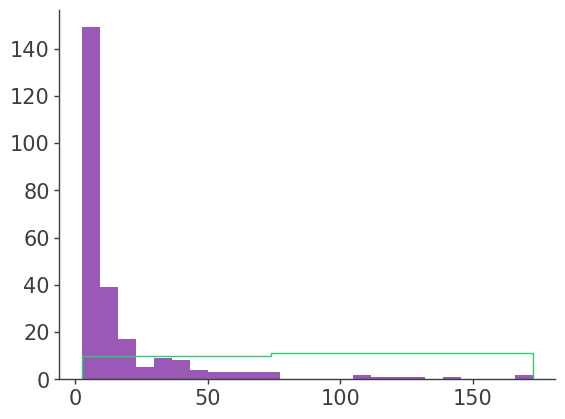

In [8]:
%matplotlib inline
event_file = pyfits.open(myLATdataset.filt_file)
event_times = sorted(event_file["EVENTS"].data["TIME"] - myGRB["MET"])
intervals = event_times[0::10]
_ = plt.hist(event_times)
_ = plt.hist(event_times, intervals, histtype="step")
# plt.show()

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
tstops = tstops[:-1].replace("-", "\\-")

We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                                       190114873
roi                                                                  10
tstarts               2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.54...
tstops                3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.98...
zmax                                                              110.0
emin                                                              100.0
emax                                                           100000.0
irf                                                    p8_transient020e
galactic_model                                                 template
particle_model                                           isotr template
source_model                                                  PowerLaw2
tsmin                                                              20.0
strategy                                                           time
thetamax                                                        

In [11]:
tstops

'3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754'

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [12]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

         INFO      Changing permission to                                              ]8;id=652605;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=936944;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py                                                      

         INFO      Changing permission to                                              ]8;id=47581;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=682665;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtdiffrsp_mp.py                                                          

         INFO      Changing permission to                                              ]8;id=648538;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=965702;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtexpmap_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=387070;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=487372;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtltcube_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=930981;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=596287;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gttsmap_mp.py                                                            

         INFO      About to run the following command:                                 ]8;id=636163;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=93851;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#640\640]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.68                             
                  89,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165                             
                  ,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262' --tstops                                       
                  '3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.01                             
                  17,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.783                             
                  4,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754' --zmax                                       
                  110.000000 --emin 100.000000 --emax 100000.000000 --irf                                          
                  'p8_transient020e' --galactic_model 'template' --particle_model                                  
                  'isotr template' --source_model 'PowerLaw2' --tsmin 20.000000                                    
                  --strategy 'time' --thetamax 180.000000 --spectralfiles 'no'                                     
                  --liketype 'unbinned' --optimizeposition 'no' --datarepository '.'                               
                  --ltcube '' --expomap '' --ulphindex -2.000000 --flemin 100.000000                               
                  --flemax 10000.000000 --fgl_mode 'fast'                                                          

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   25.19240     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .29E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.71579     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .58E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
2.6996               - 3.6358
3.6358               - 3.9968
3.9968               - 4.4024
4.4024               - 4.7375
4.7375               - 5.0909
5.0909               - 5.5471
5.5471               - 5.9896
5.9896               - 6.3998
6.3998               - 6.6889
6.6889               - 7.0117
7.0117               - 7.2936
7.2936               - 7.7731
7.7731               - 8.2167
8.2167               - 8.8763
8.8763               - 9.6573
9.6573               - 10.568
10.568               - 12.0568
12.0568              - 14.6165
14.6165              - 17.7834
17.7834              - 21.4962
21.4962              - 30.0798
30.0798              - 40.8747
40.8747              - 48.7118
48.7118              - 73.7262
73.7262              - 172.5754

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file      

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   4.786573     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   5.901543     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .70E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtexpmap_mp.py 40 40 2 2 /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit gll_ft1_tr_bn190114873_v00_filt_ltcube.fit P8R3_TRANSIENT020E_V3 20.0 20 gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Starting calculation of region 20.0,0.0 to 40.0,20.0

Completed calculation of region 20.0,0.0 to 40.0,20.0

Spawning 4 jobs...

Combining temporary files...

Deleting temporary files...



time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_3.6358-3.9968.xml irfs="P8R3_TRAN

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.43105     FROM MIGRAD    STATUS=CONVERGED     67 CALLS       68 TOTAL
                     EDM=   .19E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_4.4024-4.7375.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.15
user 0.13
sys 0.01

Total number of events in the counts map: 10
Total time in Good Time Intervals:        0.3350999355316162
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_4.4024-4.7375.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' 

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   11.37565     FROM MIGRAD    STATUS=CONVERGED     74 CALLS       75 TOTAL
                     EDM=   .16E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  9.4%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   7.632503     FROM MIGRAD    STATUS=CONVERGED     61 CALLS       62 TOTAL
                     EDM=   .99E-06  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  5.3%

  EXT PARAMETER                            

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   145|
|                    |       Integral|    0.0202|     0.00667| ph./cm2/s|      |
|                    |          Index|     -2.16|       0.362|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  1.23e-05|    5.57e-06| erg/cm2/s|      |
|                    |    Photon flux|    0.0201|     0.00668| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   10.79486     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .15E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   6.844639     FROM MIGRAD    STATUS=CONVERGED     66 CALLS       67 TOTAL
                     EDM=   .31E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_5.5471-5.9896.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_5.5471-5.9896.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.64
user 0.32
sys 0.30
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   8.317516     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .68E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_6.3998-6.6889.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='6.3998' tstop='6.6889' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   12.58093     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .10E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   18.30164     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_6.6889-7.0117.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 6.98
user 6.10
sys 0.71
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   14.90094     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .44E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_7.2936-7.7731.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.16
user 0.14
sys 0.02

Total number of events in the counts map: 10
Total time in Good Time Intervals:        0.47950005531311035
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_7.2936-7.7731.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast'

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   13.18701     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .24E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.5%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   24.59086     FROM MIGRAD    STATUS=CONVERGED     57 CALLS       58 TOTAL
                     EDM=   .13E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   128|
|                    |       Integral|     0.018|     0.00597| ph./cm2/s|      |
|                    |          Index|     -2.62|       0.447|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  7.11e-06|    2.74e-06| erg/cm2/s|      |
|                    |    Photon flux|     0.018|     0.00597| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     1|
|                    |          Value|         1|       0.134|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   28.24928     FROM MIGRAD    STATUS=CONVERGED     56 CALLS       57 TOTAL
                     EDM=   .18E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   29.59265     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .12E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_8.8763-9.6573.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_8.8763-9.6573.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval8.8763-9.6573/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.95
user 0.38
sys 0.41
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   30.55516     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .11E-04  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.1%

  EXT PARAMETER                            

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_10.568-12.0568.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='10.568' tstop='12.0568' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn19011487

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   29.31981     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .64E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  3.9%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   38.58473     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .91E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  4.2%

  EXT PARAMETER                            

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_12.0568-14.6165.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 7.40
user 6.77
sys 0.60
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/th

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   41.85635     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .15E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_17.7834-21.4962.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.18
user 0.15
sys 0.02

Total number of events in the counts map: 11
Total time in Good Time Intervals:        3.712799906730652
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_17.7834-21.4962.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fas

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   40.63160     FROM MIGRAD    STATUS=CONVERGED     71 CALLS       72 TOTAL
                     EDM=   .94E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   34.58971     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .11E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   119|
|                    |       Integral|  0.000725|     0.00023| ph./cm2/s|      |
|                    |          Index|     -1.42|       0.272|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|   1.2e-06|    5.71e-07| erg/cm2/s|      |
|                    |    Photon flux|  0.000656|    0.000215| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   51.56070     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   66.71287     FROM MIGRAD    STATUS=CONVERGED     64 CALLS       65 TOTAL
                     EDM=   .42E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_40.8747-48.7118.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_40.8747-48.7118.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval40.8747-48.7118/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.67
user 0.32
sys 0.30
/

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_73.7262-172.5754.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='73.7262' tstop='172.5754' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn1901

21:22:41 INFO      The ft2 file does not exist. Please examine!                        ]8;id=958192;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=5882;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=410207;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=403897;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=144670;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=672630;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval10.568-12.0568/gll_ft2_tr_bn190114873_v00.fit                                            

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=294588;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=742365;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=604064;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=391884;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=316701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=236660;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval12.0568-14.6165/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=527976;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=565172;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=201804;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=63338;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=690621;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=954082;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval14.6165-17.7834/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=185518;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=14710;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=490652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=408299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=427209;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=612420;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval17.7834-21.4962/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=661344;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=327288;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=295271;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=775736;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=411442;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=349536;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval2.6996-3.6358/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=556366;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=343089;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=357454;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=388432;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=175895;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=153524;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval21.4962-30.0798/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=320364;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=6330;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=11721;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=341418;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=232974;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=69387;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.6358-3.9968/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=445099;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=552564;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=419930;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=338549;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=614511;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=892472;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.9968-4.4024/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=563866;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=530524;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=235853;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=64009;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=98122;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=157602;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval30.0798-40.8747/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=634383;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=73067;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=891163;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=652454;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=384643;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=758349;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.4024-4.7375/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=934549;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=637288;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=510536;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=935311;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=744135;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=53064;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.7375-5.0909/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=696921;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=87167;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=905000;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=12678;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=860096;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=634876;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval40.8747-48.7118/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=833045;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=109424;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=638620;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=692884;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=556045;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=434645;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval48.7118-73.7262/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=166171;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=102427;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=536414;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=153637;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=632265;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=262682;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.0909-5.5471/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=552209;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=209979;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=495266;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=308080;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=583033;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=794465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.5471-5.9896/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=618342;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=717895;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=811164;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=161108;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=572827;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=730405;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.9896-6.3998/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=729475;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=213595;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=764168;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=765895;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=819896;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=970755;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.3998-6.6889/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=244633;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=191387;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=636102;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=176488;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=353469;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=650979;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.6889-7.0117/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=268442;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=469488;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=605756;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=373035;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=103895;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=621212;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.0117-7.2936/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=399922;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=467850;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=891793;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=85285;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=555144;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=2494;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.2936-7.7731/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=195820;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=143523;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=374289;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=628011;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=667365;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=298134;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.7731-8.2167/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=356984;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=257649;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=866006;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=963409;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=950409;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=635940;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval73.7262-172.5754/gll_ft2_tr_bn190114873_v00.fit                                          

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=892197;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=818935;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=792784;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=361777;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=975817;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=734606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.2167-8.8763/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=37299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=565766;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=659215;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=61393;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=536466;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=796650;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.8763-9.6573/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=575350;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=256616;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=839693;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=460836;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

21:22:42 INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=178652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=229992;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval9.6573-10.568/gll_ft2_tr_bn190114873_v00.fit                                             

 At this point we can create the FermiLATLike plugins from each of the observation:

In [13]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  1.488800048828125
FermiLATLike - GTI SUM =  2.5597000122070312


FermiLATLike - GTI SUM =  3.1669000387191772
FermiLATLike - GTI SUM =  3.712799906730652


FermiLATLike - GTI SUM =  0.9362000226974487
FermiLATLike - GTI SUM =  8.583600044250488


FermiLATLike - GTI SUM =  0.3609999418258667


FermiLATLike - GTI SUM =  0.40560007095336914
FermiLATLike - GTI SUM =  10.794899940490723


FermiLATLike - GTI SUM =  0.3350999355316162


FermiLATLike - GTI SUM =  0.35339999198913574


FermiLATLike - GTI SUM =  7.837100028991699
FermiLATLike - GTI SUM =  25.014400005340576


FermiLATLike - GTI SUM =  0.4562000036239624


FermiLATLike - GTI SUM =  0.4424999952316284
FermiLATLike - GTI SUM =  0.41019999980926514


FermiLATLike - GTI SUM =  0.2891000509262085


FermiLATLike - GTI SUM =  0.32280004024505615
FermiLATLike - GTI SUM =  0.28189992904663086


FermiLATLike - GTI SUM =  0.47950005531311035


FermiLATLike - GTI SUM =  0.4435999393463135


FermiLATLike - GTI SUM =  98.84920001029968


FermiLATLike - GTI SUM =  0.659600019454956


FermiLATLike - GTI SUM =  0.781000018119812
FermiLATLike - GTI SUM =  0.9106999635696411


For reference, these are the keys save in the dictionary.


In [14]:
LAT_plugins.keys()

dict_keys(['LAT_10.568-12.057', 'LAT_12.057-14.617', 'LAT_14.617-17.783', 'LAT_17.783-21.496', 'LAT_02.700-03.636', 'LAT_21.496-30.080', 'LAT_03.636-03.997', 'LAT_03.997-04.402', 'LAT_30.080-40.875', 'LAT_04.402-04.737', 'LAT_04.737-05.091', 'LAT_40.875-48.712', 'LAT_48.712-73.726', 'LAT_05.091-05.547', 'LAT_05.547-05.990', 'LAT_05.990-06.400', 'LAT_06.400-06.689', 'LAT_06.689-07.012', 'LAT_07.012-07.294', 'LAT_07.294-07.773', 'LAT_07.773-08.217', 'LAT_73.726-172.575', 'LAT_08.217-08.876', 'LAT_08.876-09.657', 'LAT_09.657-10.568'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [15]:
results = {}
update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

21:22:51 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=840688;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=470925;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

21:22:51 DEBUG     creating new MLE analysis                                                 ]8;id=864763;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=998574;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=272543;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357894;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:01 DEBUG     Removing non-needed files                                                    ]8;id=46337;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=164593;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=617457;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=816558;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=780423;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=746618;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=355395;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=335637;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=469129;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=568058;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=963201;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=6681;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=478778;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=408366;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=176020;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=149055;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=480284;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=612424;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=125010;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=704298;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.035850408347845                       ]8;id=775545;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=720888;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.999991708177062                   ]8;id=741778;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=250902;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT2X3_IsotropicTemplate_Normalization = 4.9998262064715675                  ]8;id=107163;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=285086;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=884800;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=610224;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -41 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=176762;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=518362;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   75.32 percent of samples have been thrown away because they failed the  ]8;id=47350;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=496593;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(9.2 -2.5 +3.4) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0033,
LAT2X3_IsotropicTemplate_Normalization,5.0 +/- 0.4,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT2X3,40.664992
total,40.664992


Values of statistical measures:

,statistical measures
AIC,91.329983
BIC,88.237739


21:23:01 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=537236;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=366060;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=760070;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=979306;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=73490;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=705992;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:09 DEBUG     Removing non-needed files                                                    ]8;id=908942;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=210214;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=292893;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=827123;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=479035;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=814722;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=881184;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=784899;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=833184;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223977;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=734431;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=359712;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=862932;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=365751;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=832353;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=602272;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=389961;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65935;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=174993;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=586343;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6218053649739153                      ]8;id=837978;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=769679;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9999932121176722                  ]8;id=487105;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=911081;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X3_IsotropicTemplate_Normalization = 4.997384151781968                   ]8;id=338999;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=661209;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=494764;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=208603;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -30 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=424597;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194810;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   75.2 percent of samples have been thrown away because they failed the   ]8;id=158577;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=126965;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.4 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0026,
LAT3X3_IsotropicTemplate_Normalization,5.0 +/- 1.5,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,-0.00
-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X3,29.516899
total,29.516899


Values of statistical measures:

,statistical measures
AIC,69.033798
BIC,65.941553


21:23:09 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=467624;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=945473;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=393389;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=143473;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=267790;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=192828;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:17 DEBUG     Removing non-needed files                                                    ]8;id=872549;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=110213;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=612725;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=726028;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=899479;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=337949;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=124807;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=540190;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=207489;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947848;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=983091;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=871236;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=916820;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=534258;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=588724;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468965;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=926850;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=550394;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=879075;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=422841;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6739857264716593                      ]8;id=255233;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=563587;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9704822069906327                  ]8;id=485555;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=309083;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X4_IsotropicTemplate_Normalization = 0.10022644625362875                 ]8;id=659426;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=35607;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=394109;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=488916;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -20 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=63988;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=738038;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   75.14 percent of samples have been thrown away because they failed the  ]8;id=816003;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=180471;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.1 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0 +/- 0.5,
LAT3X4_IsotropicTemplate_Normalization,(1 +/- 9) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X4,19.890361
total,19.890361


Values of statistical measures:

,statistical measures
AIC,49.780722
BIC,46.688478


21:23:17 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=741934;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=373790;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=851851;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315611;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=569884;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487966;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:24 DEBUG     Removing non-needed files                                                    ]8;id=777683;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=756292;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=997245;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=559678;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=22341;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=836129;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

21:23:25 DEBUG     removed {temp_file}                                                          ]8;id=6450;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=62682;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=750583;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=817652;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=339403;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=912937;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=401077;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347815;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=240194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=134193;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=418648;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=240525;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=13973;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=886561;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355708839216427                      ]8;id=512588;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=136142;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.492533539531339                   ]8;id=516489;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=819403;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X4_IsotropicTemplate_Normalization = 0.10000066202558072                 ]8;id=542530;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=172209;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=617526;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=807852;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -21 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=153550;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=386764;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   55.66 percent of samples have been thrown away because they failed the  ]8;id=799734;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=658256;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


21:23:25 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=984697;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=202195;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=136016;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=255484;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=77862;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=6407;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:32 DEBUG     Removing non-needed files                                                    ]8;id=429436;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=799002;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=647399;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=981270;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=354904;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=181666;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=273587;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=357720;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=671429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257606;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=875631;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358717;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=776862;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=685765;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=379915;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=797850;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=695370;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=747167;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=290705;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=158378;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.69751554407834                        ]8;id=660688;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=657836;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1555843829138626                  ]8;id=349842;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=142129;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X5_IsotropicTemplate_Normalization = 0.10002834867420268                 ]8;id=766595;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=495852;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=400162;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=280269;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -29 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=386328;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=898975;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   51.44 percent of samples have been thrown away because they failed the  ]8;id=170579;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=973646;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT4X5_IsotropicTemplate_Normalization,(1.0 +/- 3.0) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X5,28.534664
total,28.534664


Values of statistical measures:

,statistical measures
AIC,67.069327
BIC,63.977083


21:23:32 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=1946;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=989781;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=930933;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=530218;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=836036;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=803990;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:40 DEBUG     Removing non-needed files                                                    ]8;id=94960;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=340061;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=562813;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=862127;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=673375;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=821231;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=362634;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=897965;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=516744;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=958591;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=947806;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=319906;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=203141;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=498200;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=962096;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406234;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=737078;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=969456;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=772151;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=596225;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9619951685801957                      ]8;id=82524;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=907493;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.357787396251045                   ]8;id=823118;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=636982;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10007214359718819                 ]8;id=870081;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=945424;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=612163;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=597905;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -24 , Free Parameters: 3, Total number of datapoints: 9      ]8;id=114826;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=452341;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.03999999999999 percent of samples have been thrown away because they ]8;id=283606;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=922790;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.09 -0.32 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.36 +/- 0.28,
LAT5X5_IsotropicTemplate_Normalization,(1 +/- 5) x 10^-1,


Correlation matrix:

1.00,-0.25,-0.00
-0.25,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,24.177478
total,24.177478


Values of statistical measures:

,statistical measures
AIC,59.154956
BIC,54.946630


21:23:40 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=206638;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=701975;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=773736;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=799216;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=464994;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=2258;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:48 DEBUG     Removing non-needed files                                                    ]8;id=975867;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=445937;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=35593;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=596016;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=715682;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=384148;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=389507;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=681795;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=559025;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=547336;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=557923;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=805265;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=293054;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=950586;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=783327;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347106;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=116726;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342699;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

21:23:49 DEBUG     Restoring best fit:                                                          ]8;id=120846;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=580169;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7988559367529733                      ]8;id=440510;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=564776;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1236975151251234                  ]8;id=253066;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=134647;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10278726281245283                 ]8;id=797933;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=817922;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=290874;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=688623;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -23 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=171826;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=853405;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   51.68000000000001 percent of samples have been thrown away because they ]8;id=112364;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=693673;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.6 -0.4 +0.6) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.1 +/- 0.4,
LAT5X5_IsotropicTemplate_Normalization,0.1 +/- 2.4,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,22.736916
total,22.736916


Values of statistical measures:

,statistical measures
AIC,55.473833
BIC,52.381588


21:23:49 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=514729;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=910795;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=3806;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118856;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=44201;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=245761;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:23:56 DEBUG     Removing non-needed files                                                    ]8;id=948750;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=181426;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=307287;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=277931;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=145821;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=298865;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=184104;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=559838;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=409440;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=777287;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=185761;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707819;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=354709;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485930;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=938250;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=960148;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=141152;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=560925;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=831003;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=413191;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7207597084097388                      ]8;id=751730;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=72322;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.5179188763814526                  ]8;id=503557;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=779666;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X6_IsotropicTemplate_Normalization = 0.10000056537138591                 ]8;id=484611;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=899878;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=528513;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=582574;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -26 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=732293;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=190685;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   57.02 percent of samples have been thrown away because they failed the  ]8;id=40955;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=316199;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.9 -0.5 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT5X6_IsotropicTemplate_Normalization,(1.0 +/- 0.5) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X6,25.898652
total,25.898652


Values of statistical measures:

,statistical measures
AIC,61.797305
BIC,58.705060


21:23:56 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=607259;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=780396;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=447523;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=997078;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=18740;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=336366;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:03 DEBUG     Removing non-needed files                                                    ]8;id=60200;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=79847;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=455965;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=191838;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=526893;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=582495;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=737540;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=733873;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=746019;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356296;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=774612;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=477283;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=267566;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=834296;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=4565;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=747938;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=266363;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=120483;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=131560;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=807690;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.5964520921915943                      ]8;id=217633;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=51814;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.9399187221889842                  ]8;id=199735;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=877987;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X6_IsotropicTemplate_Normalization = 0.10000980163931177                 ]8;id=459689;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=992867;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=398063;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=311079;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -24 , Free Parameters: 3, Total number of datapoints: 11     ]8;id=636588;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=439734;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   49.6 percent of samples have been thrown away because they failed the   ]8;id=631032;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=525139;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.5 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.94 +/- 0.31,
LAT6X6_IsotropicTemplate_Normalization,(1.0 +/- 2.1) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X6,24.346796
total,24.346796


Values of statistical measures:

,statistical measures
AIC,58.122163
BIC,55.887278


21:24:03 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=609768;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=172540;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=671280;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=897109;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=924266;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773386;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:09 DEBUG     Removing non-needed files                                                    ]8;id=48407;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=23555;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=473599;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=572730;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=263507;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=436882;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=935365;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=480505;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=11548;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=491610;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=787245;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885354;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=157235;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95375;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=263553;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801107;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=179548;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433936;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

21:24:10 DEBUG     Restoring best fit:                                                          ]8;id=778566;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=137094;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6921001026063185                      ]8;id=510288;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=268931;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.2578600601426784                  ]8;id=560254;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=38897;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X7_IsotropicTemplate_Normalization = 4.971986892239891                   ]8;id=451984;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=751446;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=752466;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=155457;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -21 , Free Parameters: 3, Total number of datapoints: 9      ]8;id=904655;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=209517;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   89.36 percent of samples have been thrown away because they failed the  ]8;id=824672;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=640493;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.3 +/- 0.4,
LAT6X7_IsotropicTemplate_Normalization,(0.5 +/- 1.8) x 10,


Correlation matrix:

1.00,-0.31,-0.01
-0.31,1.00,0.01
-0.01,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X7,21.118623
total,21.118623


Values of statistical measures:

,statistical measures
AIC,53.037245
BIC,48.828919


21:24:10 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=81858;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=414779;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=914500;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=69009;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=823445;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=846412;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:18 DEBUG     Removing non-needed files                                                    ]8;id=396972;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=492035;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=349745;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=896411;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=552719;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=657888;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=424776;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=916181;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=227537;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=75243;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=18884;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930770;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=819489;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=29824;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=331371;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=151141;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=179874;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=46729;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=788367;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=760674;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355267962096465                      ]8;id=101387;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=514826;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8761370498083396                  ]8;id=582355;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=392548;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.10005170951183916                 ]8;id=822887;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=321657;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=718636;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=738829;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -28 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=75124;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=266756;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   51.019999999999996 percent of samples have been thrown away because     ]8;id=935770;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=415967;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.88 +/- 0.32,
LAT7X7_IsotropicTemplate_Normalization,(1 +/- 4) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,27.684882
total,27.684882


Values of statistical measures:

,statistical measures
AIC,65.369764
BIC,62.277519


21:24:18 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=313992;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=33332;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=428058;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737911;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=583780;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984644;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:25 DEBUG     Removing non-needed files                                                    ]8;id=974892;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=146861;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=833320;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=783313;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=70820;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=20300;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=112495;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=589699;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=54082;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=819077;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=208178;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=326868;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=128933;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=110544;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=689887;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=545050;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=689200;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=651776;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=47071;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.874407444120822                       ]8;id=7348;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=225652;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8167269261282395                  ]8;id=645062;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=935707;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.101118521519397                   ]8;id=934137;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=856247;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=757224;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=497526;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -33 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=680386;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=782032;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   49.62 percent of samples have been thrown away because they failed the  ]8;id=105136;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=943495;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.3 -0.4 +0.5) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.82 +/- 0.31,
LAT7X7_IsotropicTemplate_Normalization,0.1 +/- 1.7,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,33.405978
total,33.405978


Values of statistical measures:

,statistical measures
AIC,76.811955
BIC,73.719711


21:24:25 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=727702;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=946664;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=96738;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194533;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=131957;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=528629;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:32 DEBUG     Removing non-needed files                                                    ]8;id=599086;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=186052;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=653148;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=488253;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=157429;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=800941;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=653850;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=282260;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=182582;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=897462;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=65800;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=634474;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=141655;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332683;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=64756;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119077;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=502045;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12155;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=265619;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=172072;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.745332153348909                       ]8;id=904757;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=185843;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.615089775519224                   ]8;id=202904;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=499090;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X8_IsotropicTemplate_Normalization = 4.9984007089917                     ]8;id=312934;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=296092;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=51655;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=22125;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -30 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=487216;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=209582;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   59.24 percent of samples have been thrown away because they failed the  ]8;id=88819;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=243605;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.6 +/- 0.5,
LAT7X8_IsotropicTemplate_Normalization,5.0 +/- 1.2,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X8,29.99633
total,29.99633


Values of statistical measures:

,statistical measures
AIC,69.992660
BIC,66.900416


21:24:32 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=485784;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=70707;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=767832;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138512;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=223411;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=281130;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:39 DEBUG     Removing non-needed files                                                    ]8;id=585566;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=374653;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=547385;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=503221;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=378943;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=985639;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=526380;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=144550;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=677440;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=563875;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=404564;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851230;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=530427;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320626;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=485121;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246682;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=195254;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=691373;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=419181;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=590415;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.966919994271686                       ]8;id=934093;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=449139;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.167684025524464                   ]8;id=844107;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=926799;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X8_IsotropicTemplate_Normalization = 0.10024120943558205                 ]8;id=202324;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=433408;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=380506;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=461107;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -28 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=538527;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=148625;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.839999999999996 percent of samples have been thrown away because     ]8;id=943221;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=870244;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.08 -0.31 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT8X8_IsotropicTemplate_Normalization,(1 +/- 8) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X8,28.291424
total,28.291424


Values of statistical measures:

,statistical measures
AIC,66.582848
BIC,63.490603


21:24:39 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=444962;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=133108;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=403729;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753755;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=732933;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564235;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:47 DEBUG     Removing non-needed files                                                    ]8;id=327079;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=273745;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=483540;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=534380;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=325428;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=960422;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=116362;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=335464;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=397107;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=763879;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=474600;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=956796;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=308767;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103540;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=36949;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=783913;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=382260;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930397;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=727788;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=372475;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9989307667694747                      ]8;id=663020;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=949652;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1742660371809626                  ]8;id=629442;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=768523;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X9_IsotropicTemplate_Normalization = 4.999904165040313                   ]8;id=583917;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=413278;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=903619;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=690127;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -42 , Free Parameters: 3, Total number of datapoints: 11     ]8;id=46677;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=469514;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   49.919999999999995 percent of samples have been thrown away because     ]8;id=630727;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=217038;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.00 -0.27 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.17 +/- 0.35,
LAT8X9_IsotropicTemplate_Normalization,5.00 +/- 0.27,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X9,42.084703
total,42.084703


Values of statistical measures:

,statistical measures
AIC,93.597977
BIC,91.363091


21:24:47 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=512616;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=473474;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=123517;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=48872;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=792714;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54048;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:24:53 DEBUG     Removing non-needed files                                                    ]8;id=540827;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=152038;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=913183;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=273658;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=654777;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=621167;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=979421;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=836051;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=160931;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=319558;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=779924;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=551263;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=977748;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928855;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=144738;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=353412;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=276272;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=462696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=253246;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=562073;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.1682899419752197                      ]8;id=389363;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=878461;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7278761567405359                  ]8;id=115321;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=799181;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT9X10_IsotropicTemplate_Normalization = 4.999974002396179                  ]8;id=907758;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=587388;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=945583;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=39327;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -43 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=57043;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582015;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.480000000000004 percent of samples have been thrown away because     ]8;id=299529;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=279938;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.8 -1.9 +2.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.30,
LAT9X10_IsotropicTemplate_Normalization,5.00 +/- 0.07,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT9X10,43.319201
total,43.319201


Values of statistical measures:

,statistical measures
AIC,96.638402
BIC,93.546158


21:24:54 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=77824;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=964221;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

21:24:54 DEBUG     creating new MLE analysis                                                 ]8;id=212656;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608935;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=81254;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259823;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:00 DEBUG     Removing non-needed files                                                    ]8;id=237722;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=761527;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=603252;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=247024;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=919324;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=765409;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=488831;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=625165;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=241054;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=965286;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=593223;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=594983;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=177365;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=754953;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=676574;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=43449;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=929190;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=185900;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=818974;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=653164;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.4181766100254074                      ]8;id=868208;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=349085;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4634240053704302                  ]8;id=371905;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=450709;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT10X12_IsotropicTemplate_Normalization = 4.9999925794176905                ]8;id=83768;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=516024;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=925001;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=326602;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -45 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=363089;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355127;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   49.1 percent of samples have been thrown away because they failed the   ]8;id=443561;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=445696;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.8 -1.1 +1.5) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.46 +/- 0.28,
LAT10X12_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.27,0.00
-0.27,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X12,44.676283
total,44.676283


Values of statistical measures:

,statistical measures
AIC,99.352567
BIC,96.260322


21:25:00 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=884111;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=529830;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=403406;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=182759;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=262514;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=719477;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:08 DEBUG     Removing non-needed files                                                    ]8;id=168316;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=381205;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=663302;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=452433;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=256328;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=69439;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=778236;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=266256;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=193974;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=289131;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=352354;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=977068;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=156055;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=164893;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=120816;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=831757;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=844285;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=734541;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=435293;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=399764;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.5666975566847854                      ]8;id=151127;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=55596;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.4716815853065044                  ]8;id=351601;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=720187;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT12X14_IsotropicTemplate_Normalization = 0.10000005244652592               ]8;id=265540;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=528911;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=306783;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=920104;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -43 , Free Parameters: 3, Total number of datapoints: 9      ]8;id=216593;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=276157;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   55.96 percent of samples have been thrown away because they failed the  ]8;id=641337;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=643227;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.7 -0.8 +1.1) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT12X14_IsotropicTemplate_Normalization,(1.00 +/- 0.07) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT12X14,43.35698
total,43.35698


Values of statistical measures:

,statistical measures
AIC,97.513960
BIC,93.305634


21:25:08 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=676196;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=76933;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=868272;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270700;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=649067;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825315;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:15 DEBUG     Removing non-needed files                                                    ]8;id=543861;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=387152;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=885574;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=794066;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=688163;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=936091;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=934388;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=163893;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=241407;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167476;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=570991;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=222736;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=516261;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=219136;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=873879;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=551725;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=455913;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=108696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=370047;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=631326;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.699064502270993                       ]8;id=145963;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=553945;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7831868025545965                  ]8;id=858795;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=945467;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT14X17_IsotropicTemplate_Normalization = 0.10001890630551728               ]8;id=427785;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=354874;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=948605;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=914691;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -44 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=435917;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=490387;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.839999999999996 percent of samples have been thrown away because     ]8;id=124248;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=134183;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.78 +/- 0.31,
LAT14X17_IsotropicTemplate_Normalization,(1.0 +/- 1.1) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT14X17,44.424215
total,44.424215


Values of statistical measures:

,statistical measures
AIC,98.848429
BIC,95.756184


21:25:15 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=584487;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=228887;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=51238;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167604;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=411918;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=115794;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:22 DEBUG     Removing non-needed files                                                    ]8;id=833200;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=92131;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=606887;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=303720;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=209445;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=139537;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=103519;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=699220;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=133561;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=835796;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=682613;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=605521;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=837983;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=324239;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=253415;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874527;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=90413;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=908905;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=483913;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=537835;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.735356921067409                       ]8;id=767778;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=223732;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.72394312547533                    ]8;id=394148;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=906498;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT17X21_IsotropicTemplate_Normalization = 0.10724605578727957               ]8;id=868647;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=16698;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=826611;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=127004;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -56 , Free Parameters: 3, Total number of datapoints: 11     ]8;id=821438;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241453;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.739999999999995 percent of samples have been thrown away because     ]8;id=647065;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=784613;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.72 +/- 0.28,
LAT17X21_IsotropicTemplate_Normalization,0.1 +/- 1.9,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT17X21,56.087076
total,56.087076


Values of statistical measures:

,statistical measures
AIC,121.602723
BIC,119.367837


21:25:22 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=732261;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=909221;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=721629;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506910;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=23453;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963284;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:29 DEBUG     Removing non-needed files                                                    ]8;id=120272;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=986672;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=9236;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=245345;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=74867;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=453022;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=517750;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=928039;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=339298;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=508351;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=137744;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=508090;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=470479;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745203;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=496965;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930877;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=175048;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=902337;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=142168;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=491487;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.183583779903508                       ]8;id=166254;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=955186;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4193207340806755                  ]8;id=437440;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=601505;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT21X30_IsotropicTemplate_Normalization = 0.1000025649287333                ]8;id=499131;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=449955;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=625544;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=256222;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -57 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=211007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564863;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   49.24 percent of samples have been thrown away because they failed the  ]8;id=385521;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=435635;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.6 -1.8 +2.5) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.42 +/- 0.27,
LAT21X30_IsotropicTemplate_Normalization,(1.00 +/- 0.17) x 10^-1,


Correlation matrix:

1.00,-0.26,0.00
-0.26,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT21X30,56.960686
total,56.960686


Values of statistical measures:

,statistical measures
AIC,123.921371
BIC,120.829127


21:25:29 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=625397;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=855767;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=455770;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=866490;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=329797;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=639135;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:35 DEBUG     Removing non-needed files                                                    ]8;id=586189;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=995114;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=468363;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=596418;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=58225;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=107448;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=683213;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=194186;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=816518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=854251;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=63395;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728515;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=38709;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=833380;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=787628;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406476;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=691640;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=252161;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=453930;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=522053;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.3039094344689683                      ]8;id=96076;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=255810;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.2935390386846415                  ]8;id=163533;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=694342;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT30X40_IsotropicTemplate_Normalization = 4.999022159842624                 ]8;id=291267;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=568025;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=442363;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=665267;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -56 , Free Parameters: 3, Total number of datapoints: 10     ]8;id=207654;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=965031;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

21:25:36 WARNING   50.94 percent of samples have been thrown away because they failed the  ]8;id=363649;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=339798;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(5.0 -1.4 +1.9) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.29 +/- 0.26,
LAT30X40_IsotropicTemplate_Normalization,5.00 +/- 0.10,


Correlation matrix:

1.00,-0.23,-0.00
-0.23,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X40,55.835784
total,55.835784


Values of statistical measures:

,statistical measures
AIC,121.671568
BIC,118.579323


21:25:36 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=845500;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=113546;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=646471;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=904195;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=178913;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=267025;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:42 DEBUG     Removing non-needed files                                                    ]8;id=650717;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=346135;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=17197;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=830603;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=992133;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=542018;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=503463;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=917545;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=82092;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984995;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=756652;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825983;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=289962;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372047;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=131697;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=133258;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=841232;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=61488;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=408446;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=534543;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.2035661887212976                      ]8;id=895487;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=298510;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.3352365183925512                  ]8;id=557252;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=977752;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT40X48_IsotropicTemplate_Normalization = 0.10000710949138139               ]8;id=115221;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=343075;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=915239;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=855076;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -47 , Free Parameters: 3, Total number of datapoints: 9      ]8;id=949598;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=914640;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.46000000000001 percent of samples have been thrown away because they ]8;id=121325;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=793249;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.3 -1.8 +2.6) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.34 +/- 0.28,
LAT40X48_IsotropicTemplate_Normalization,(1.00 +/- 0.28) x 10^-1,


Correlation matrix:

1.00,-0.24,-0.00
-0.24,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT40X48,47.391539
total,47.391539


Values of statistical measures:

,statistical measures
AIC,105.583079
BIC,101.374752


21:25:42 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=226743;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=591703;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=204361;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=495201;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=690563;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=213755;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:49 DEBUG     Removing non-needed files                                                    ]8;id=887529;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=17354;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=840783;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=598356;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=857925;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=135947;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=324248;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=552830;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=730111;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454138;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=42904;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=542456;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=623171;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=422732;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=244268;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=597495;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=367003;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=422851;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=523702;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=578572;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.4783513422891597                      ]8;id=20797;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=660809;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8409680651588036                  ]8;id=871263;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=543334;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT48X73_IsotropicTemplate_Normalization = 0.10000154301240609               ]8;id=911567;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=390398;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=673603;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=468314;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -69 , Free Parameters: 3, Total number of datapoints: 11     ]8;id=613801;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487766;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.0 percent of samples have been thrown away because they failed the   ]8;id=732503;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=449149;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.3 -0.9 +1.2) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.84 +/- 0.30,
LAT48X73_IsotropicTemplate_Normalization,(1.00 +/- 0.09) x 10^-1,


Correlation matrix:

1.00,-0.32,0.00
-0.32,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT48X73,69.062946
total,69.062946


Values of statistical measures:

,statistical measures
AIC,147.554464
BIC,145.319579


21:25:49 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=661771;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=809321;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=31578;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=601106;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=718730;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451795;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



21:25:56 DEBUG     Removing non-needed files                                                    ]8;id=19163;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=655332;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=858751;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=204802;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=55004;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=437658;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=380315;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=497857;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=584190;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=861155;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=619178;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=535096;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=795404;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=174471;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1063\1063]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=795062;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=498167;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=954551;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891471;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=663283;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=348013;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -4.093834135421076                       ]8;id=585222;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=855715;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8351008168219356                  ]8;id=472572;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=664254;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT73X172_IsotropicTemplate_Normalization = 4.9999760211479884               ]8;id=90451;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=173976;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=183726;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=613775;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         DEBUG     likelihood: -80 , Free Parameters: 3, Total number of datapoints: 9      ]8;id=733224;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588990;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#386\386]8;;\

         WARNING   50.54 percent of samples have been thrown away because they failed the  ]8;id=602371;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=730751;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1739\1739]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(8.1 -2.7 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.8 +/- 0.4,
LAT73X172_IsotropicTemplate_Normalization,5.00 +/- 0.04,


Correlation matrix:

1.00,-0.38,-0.00
-0.38,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT73X172,79.588314
total,79.588314


Values of statistical measures:

,statistical measures
AIC,169.976627
BIC,165.768301


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


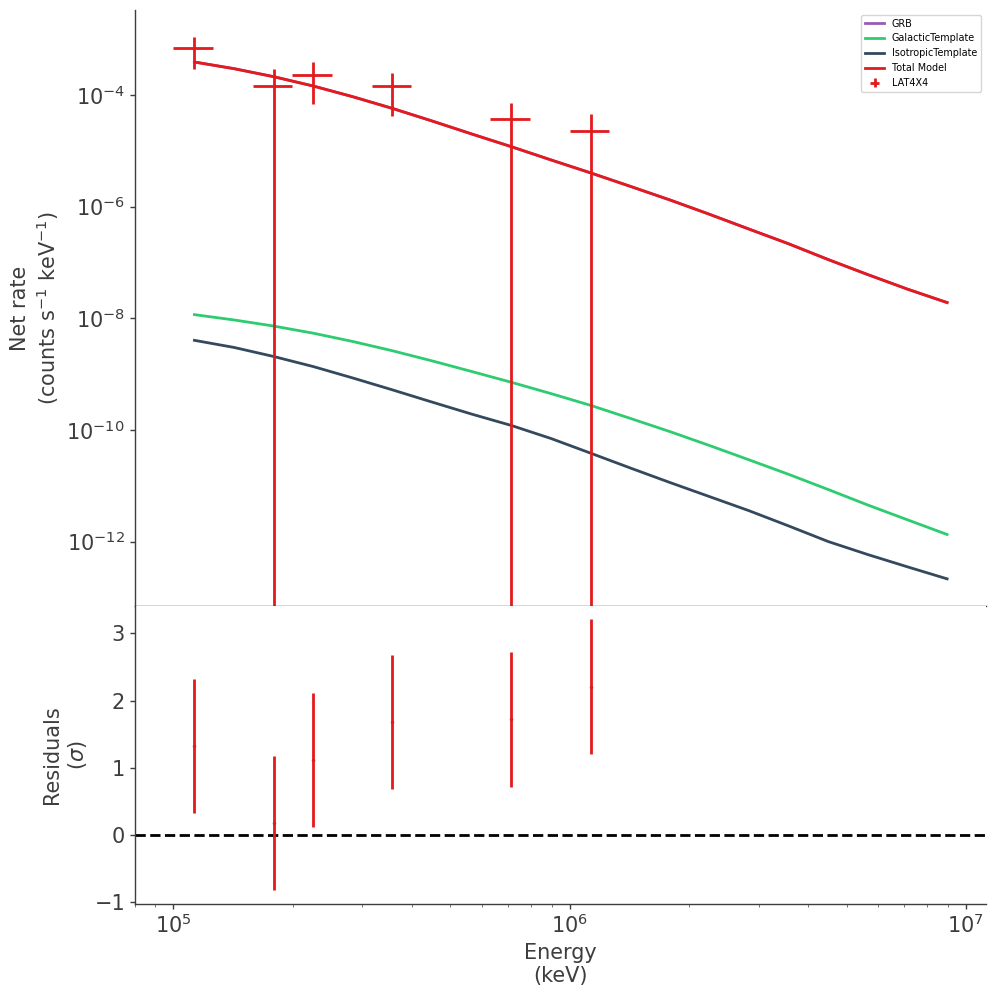

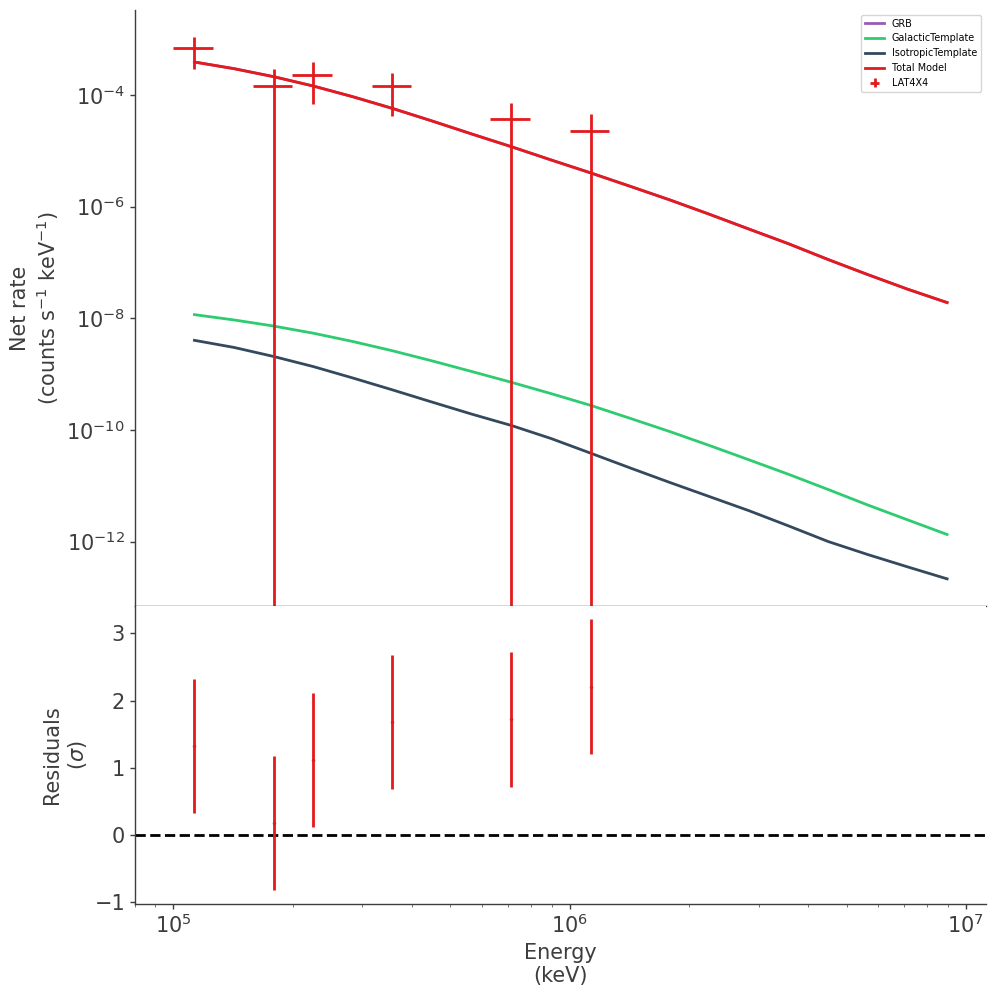

In [16]:
i = 3
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, step=False, figsize=(10, 10))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/13 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

21:27:59 DEBUG     converting MeV to MeV                                                          ]8;id=799299;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py\model_plot.py]8;;\:]8;id=368178;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py#890\890]8;;\

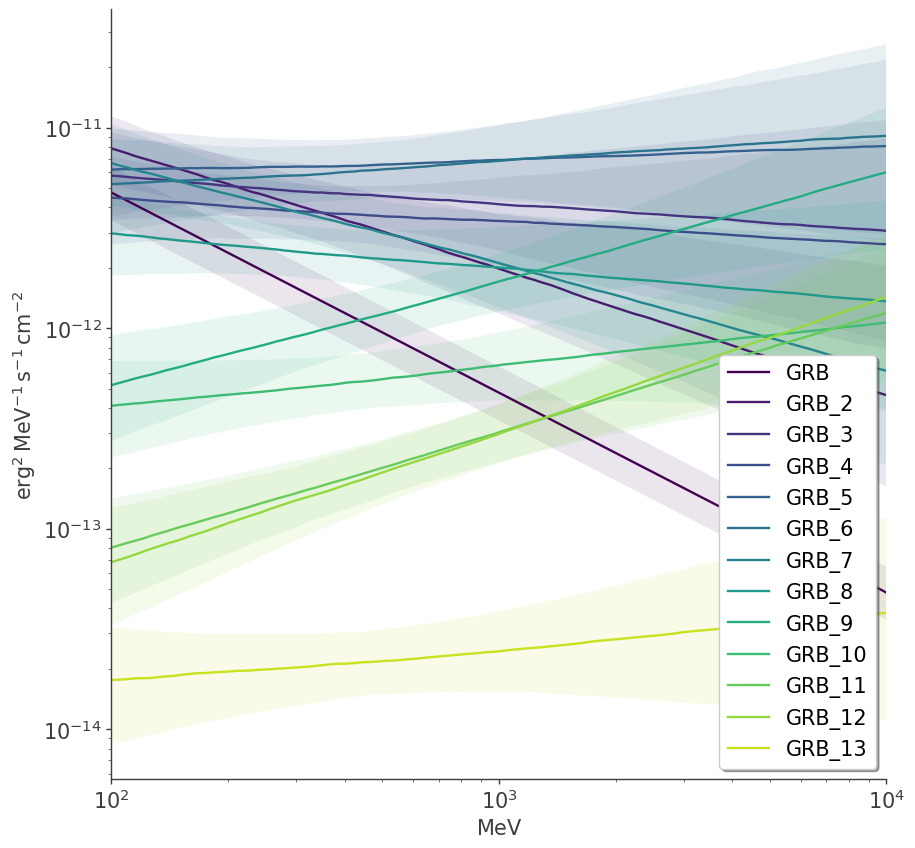

In [17]:
fig = plot_spectra(
    *[results[k].results for k in list(results.keys())[::2]],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 10)

Finally, we can display flux lightcurves and index evolution with time.


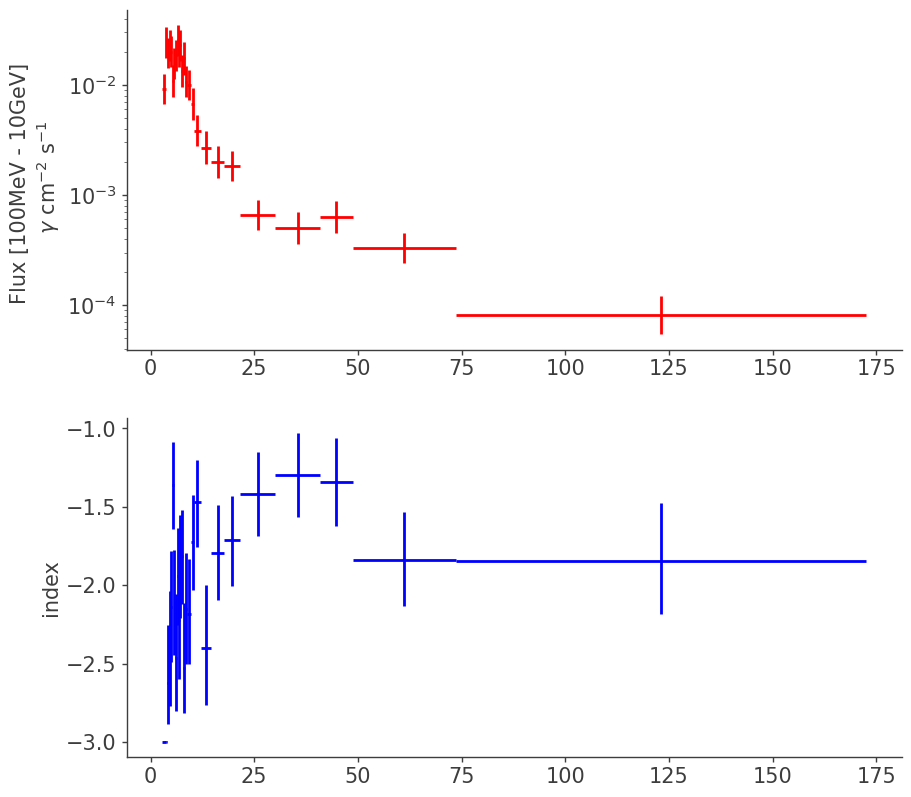

In [18]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []


for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])
        pass
    pass

fig = plt.figure(figsize=(10, 15))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    # plt.xscale('log')
    plt.ylabel(ylabels[i])
    pass